In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math

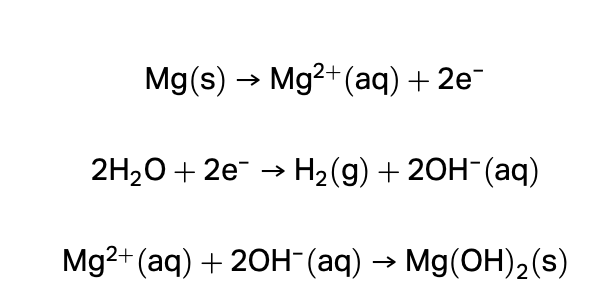

In [3]:
from IPython import display
display.Image("./PaperRxns.png")

In this notebook, the goal is to integrate the effect of chemical kinetics from the `Adding_Chemical_Reactions_2D_example.ipynb` notebook into the existing 2D version of CPFM. Specifically, the focus will be on implementing the CPFM to use the above system of chemical reactions to model the corrosion of pure $Mg_{(s)}$ due to water. 

# CPFM Functions

In [4]:
def laplace_matrix_2D_RD(Nx, Ny):
    """
    Creates the 2D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny (int), number of grid points on x- & y-axes
    Output: A_matrix (float array), 2D Laplacian discretization matrix
    """
    # initialize the Laplacian discretization matrix
    A_matrix = np.zeros((Nx*Ny, Nx*Ny))
    
    # iterate over the main diagonal
    for i in range(Nx*Ny):
        
        A_matrix[i][i] = -4 # coefficient for current cell x_i,j 
        
        if (i > 0):
            A_matrix[i-1][i] = 1 # coefficient for right neighbor x_i+1,j 
            
            if (((i + 1) % Ny == 1) and (i < Nx * Ny - 1)):
                A_matrix[i-1][i] = 0 # remove non-existent right neighbor x_i+1,j 
                                        # when reaching the end of a row       
        if (i < Nx * Ny) and (i > 0):
            A_matrix[i][i-1] = 1 # coefficient for left neighbor x_i-1,j 
            
        if (((i + 1) % Ny == 1) and (i > 2)):
            A_matrix[i][i-1] = 0 # remove non-existent left neighbor x_i-1,j 
                                        # when reaching the end of a row
                
    # np.diag() to add coefficients for top (x_i,j-1) and bottom (x_i,j+1) neighbors respectively       
    A_matrix += np.diag(np.ones(Nx * Ny - Ny), -Ny) + np.diag(np.ones(Nx * Ny - Ny), Ny)
  
    return A_matrix


def gradient_finder_2D(func):
    """
    Finds the d/dx and d/dy gradient fields of a 2D function/matrix
    NOTE : Identical to what numpy.gradient() does, however serves as
        a proof of concept for the C++ implementation
    NOTE : numpy.hstack() & .vstack() used for convenience, would be 
        replaced by simple loops in C++
    Inputs: func (float array), (Nx) x (Ny) array with entries representing function
        values for which d/dx and d/dy will be calculated
    Output: dx_func & dy_func (float array), (Nx) x (Ny) dfunc/dx & dfunc/dy arrays    
    """
    # calculate the x-derivative
        # cells in the middle have the average of the left- and right- derivatives
    x_difference = func[:, 1:]  - func[:, :-1] # defined as x_i+1,j - x_i,j
    dx_func = np.hstack((np.transpose(np.array([x_difference[:,0]])), 0.5 * (x_difference[:,1:] + x_difference[:,:-1]), np.transpose(np.array([x_difference[:,-1]]))))
    
    # calculate the y-derivative
        # cells in the middle have the average of the down- and up- derivatives
    y_difference = func[1:, :]  - func[:-1, :] # defined as x_i,j+1 - x_i,j
    dy_func = np.vstack(((np.array([y_difference[0,:]])), 0.5 * (y_difference[1:,:] + y_difference[:-1,:]), (np.array([y_difference[-1,:]]))))
    
    return dx_func, dy_func # return 2D dfunc/dx & dfunc/dy arrays   


def rho_update_2D(n_alpha, q_alpha):
    """
    Updates / computes rho^k (rho at the current time-step)
    Input: n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           q_alpha (int array), each entry represents charge of a species
    Output: rho (float array), (Nx) x (Ny) charge density array
    """
    # initialize rho to Nx x Ny size, bypass the 1st array dimension
    rho = np.zeros(np.shape(n_alpha)[1:]) 
    
    # iterate over the alphas
    for i in range(np.shape(n_alpha)[0]):
        
        rho += n_alpha[i] * q_alpha[i] # update / compute rho
        
    return rho # return 2D rho array


def phi_update_2D(a, Nx, Ny, A_matrix, rho, epsilon_0, epsilon_r): 
    """
    Updates / computes phi^k (phi at the current time-step) via
        solving Poisson's equation
    Input: a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           A_matrix (float array), 2D Laplacian discretization matrix
           rho (float array), (Nx) x (Ny) charge density array
           epsilon_0 & epsilon_r (float), constants
    Output: phi (float array), (Nx) x (Ny) electric potential array
    """
    
    c_rho = a**2 * (1.6021766e-19)**2 / (epsilon_0 * epsilon_r) # store the constant for the RHS vector

    rho_vec = rho.flatten() # from 2D to 1D
    
    # use MinRES to solve for phi^k (until you explore solver efficiency!!!!)
    phi = scipy.sparse.linalg.minres(-A_matrix, c_rho * rho_vec)[0]
    
    return phi.reshape((Nx, Ny)) # return 2D phi array


def mu_bar_alpha_update_2D(a, Nx, Ny, theta, mu_bar_alpha_0, mu_bar_alpha_1, A_alpha, epsilon): 
    """
    Updates / computes mu_bar_alpha^k (mu_bar_alpha at the current time-step)
    Input: a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           theta (float array), (Nx * Ny) array representing the flattened 2D phase
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny) mu_bar_alpha
               chemical potential arrays for the purely solid and liquid phases respectively
           A_alpha (float array), each entry represents a constant for a species
           epsilon (float), a constant scaling theta's gradient contribution 
    Output: mu_bar_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array
    """
    mu_bar_alpha = np.zeros(np.shape(mu_bar_alpha_0)) # initialize mu_bar_alpha as a 2D alpha x Nx*Ny array
    
    # store the f(theta) expression
    f_theta = theta**2 * (1 - theta)**2
    
    # store the h(theta) expression
    h_theta = theta**2 * (3 - 2 * theta)
   
    # store the gradient of theta expression (independent of alpha)
                        #dthet_dx, dthet_dy = np.gradient(0.5 * epsilon**2 * theta.reshape([Nx, Ny]))
    dtheta_dx, dtheta_dy = gradient_finder_2D(0.5 * epsilon**2 * theta.reshape([Nx, Ny]))
    
    for i in range(np.shape(mu_bar_alpha_0)[0]): # iterate over the alphas
        
        # update / compute mu_bar_alpha
        mu_bar_alpha[i] = mu_bar_alpha_0[i] + (mu_bar_alpha_1[i] - mu_bar_alpha_0[i]) * h_theta - 0.5 * A_alpha[i] * f_theta + 0.5 * epsilon**2 * (dtheta_dx.flatten()**2 + dtheta_dy.flatten()**2) 
        
    return mu_bar_alpha.reshape((np.shape(mu_bar_alpha_0)[0], Nx, Ny)) # return as a 3D alpha x Nx x Ny array
                                                                        # for easier use in mu_alpha_update()
    
def theta_update_2D(dt, a, Nx, Ny, n_alpha, theta, A_matrix, A_alpha, mu_bar_alpha_0, mu_bar_alpha_1, M, epsilon):
    """
    Updates / computes theta^(k+1) (theta at the future time-step) via 
        forward in time discretization
    Input: dt (float), size of time-step, dt
           a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           theta^k (float array), (Nx * Ny) array representing the flattened 2D phase
           A_matrix (float array), 2D Laplacian discretization matrix
           A_alpha (float array), each entry represents a constant for a species
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny) mu_bar_alpha
               arrays for the purely solid and liquid phases respectively
           M (float), a constant 
           epsilon (float), a constant scaling theta's Laplacian contribution 
    Output: theta^(k+1) (float array), (Nx * Ny) array representing the flattened 2D phase
    """
    # initialize dtheta/dt
    dtheta_dt = np.zeros(np.shape(theta))
    
    # calculate & store h'(theta) and f'(theta)
    df_dt = theta * (1 - theta) * (1 - 2 * theta)
    dh_dt = 6 * theta * (1 - theta)
    
    # save the result of the matrix-vector product 
    A_theta = A_matrix @ theta
    A_theta = np.pad((A_theta.reshape([Nx,Ny])[1:-1,1:-1]), 1)
    
    # Neumann BCs for edges
    for i in range(1,Nx):
        A_theta[i,0] = A_theta[i,1]       # left BC
        A_theta[i,Nx-1] = A_theta[i,Nx-2] # right BC
    for i in range(1,Ny):
        A_theta[0,i] = A_theta[1,i]       # top BC
        A_theta[Ny-1,i] = A_theta[Ny-2,i] # bottom BC
    A_theta[0,0] = 0.5 * (A_theta[0,1] + A_theta[1,0])                   # top left BC
    A_theta[0,Nx-1] = 0.5 * (A_theta[0,Nx-2] + A_theta[1,Nx-1])          # top right BC
    A_theta[Ny-1,0] = 0.5 * (A_theta[Ny-1,1] + A_theta[Ny-2,0])          # bottom left BC
    A_theta[Ny-1,Nx-1] = 0.5 * (A_theta[Ny-1,Nx-2] + A_theta[Ny-2,Nx-1]) # top left BC
    
    # from 2D to 1D storage
    A_theta = A_theta.flatten() 
        
    # sum over the alphas
    for i in range(np.shape(mu_bar_alpha_0)[0]):
        
        dtheta_dt += n_alpha[i].flatten() * ((mu_bar_alpha_1[i] - mu_bar_alpha_0[i]) * dh_dt - A_alpha[i] * df_dt + epsilon**2 * A_theta)
        
    # take a theta time-step
    theta += dt * M * dtheta_dt
    
    return theta


def mu_and_v_alpha_update_2D(a, T, k_B, mu_bar_alpha, q_alpha, phi, theta, D_alpha):
    """
    Input: a (float), a = dx = dy
           mu_bar_alpha (float array), (alpha) x (Nx) x (Ny) chemical potential array
           q_alpha (int array), each entry represents charge of a species
           phi (float array), (Nx) x (Ny) electric potential array
           D_alpha (float array), (alpha) x (Nx) x (Ny) diffusion coefficient array
    Output: mu_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array
            v_alpha (float array), (alpha) x (Nx) x (Ny) velocity array
    """
    # initialize mu_alpha
    mu_alpha = np.zeros(np.shape(mu_bar_alpha))

    # initialize v_alpha
    v_alpha = np.zeros(np.shape(mu_bar_alpha))
    
    # store 2D theta
    theta_2D = theta.reshape(np.shape(mu_bar_alpha)[1:])
    
    # NOTE : we want to store the exponential expression relating mu_alpha to J_alpha
        # to minimize computational cost by minimizing the np.exp() calls. This will 
        # become evident in the J_alpha_update_2D() function.
    
    c = 2 * k_B * T # store constant
    
    for i in range(np.shape(q_alpha)[0]): # loop over 1st dimension (layer) of 3D mu_alpha & v_alpha tensors
        
        #print('avg mu_bar_alpha =', i, np.sum(np.abs(mu_bar_alpha[i])))
        #print('avg q_alpha =', i, np.sum(np.abs(q_alpha[i])))
        #print('avg q_alpha * phi =', i, np.sum(np.abs(q_alpha[i] * phi)))
        #print('avg exp(mu_alpha) =', i, np.sum(np.abs(mu_alpha[i])))
        
        
        #if (i == 0):
        #    mu_e_S = 0.1
        #    mu_e_L = 0.15
        #    mu_alpha[0] = np.exp(mu_e_L * theta_2D + (1 - theta_2D) * mu_e_S)
        #else:
            # equivalent to mu_alpha = np.exp(mu_alpha/c)  
        mu_alpha[i] = np.exp((mu_bar_alpha[i] + q_alpha[i] * phi)/c) 

        v_alpha[i] = (1.0/a) * D_alpha[i] * (theta_2D + 1e-10)
        
    
    ###
    ### CHANGE THIS LATER, assume that e- is first chemical species for now
    ###
    
    
          
    return mu_alpha, v_alpha # both returned as 3D alpha x Na x Na arrays
     

In [5]:
def J_alpha_update_2D(mu_alpha, v_alpha, n_alpha):
    """
    Computes the precursor to dn_alpha/dt, J_alpha_UMat
    Input: T (float), temperature
           k_B (float), Boltzmann's constant 
           mu_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array 
           v_alpha (float array), (alpha) x (Nx) x (Ny) velocity array
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
    Output: J_alpha_UMat (float array), (alpha) x (Nx) x (Ny) particle current update array
    """
    
    # initialize J_alpha_UMat to have m x (Na) x (Na) dimensions
    J_alpha_UMat = np.zeros((np.shape(n_alpha)[0], np.shape(n_alpha)[1], np.shape(n_alpha)[2]))
    # Our update matrix which we will simply scale and then add on n_alpha_Current !!! Pretty COOL !
    
    # Our axes : +-----> (x-axis)
    #            |
    #            |
    #            v (y-axis)
    # each cell n_alpha has 4 possible neighbors, left, right, top, bottom
        # all of these neighbors exchange information to form dn/dt
        # NOTE: some cells have 2 (corner) or 3 (edge) neighbors which needs to be accounted for
    
    # now iterate over each grid index, update J_alpha_UMat values for all alphas each iteration
    
    # 1st : Deal with the Interior (Na - 2) x (Na - 2) domain
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            
            # signs given to be positive if flow into cell i,j
            J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
            J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
            J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
            J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
            
            J_alpha_UMat[:,i,j] = J_left + J_right + J_top + J_bottom
            
    
    # 2nd : Deal with the Edges
    for j in range(1, np.shape(n_alpha)[2] - 1):
        # left column
        i = 0
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_right # left column 
    
        # right column
        i = np.shape(n_alpha)[1] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_left # right column 
    
    for i in range(1, np.shape(n_alpha)[1] - 1):
    
        # top row
        j = 0
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_bottom
       
        # bottom row
        j = np.shape(n_alpha)[2] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_top   
    
    # 3rd : Deal with the Corners
    
    # top left corner
    i = 0
    j = 0
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_right 
    
    # top right corner
    i = np.shape(n_alpha)[1] - 1
    j = 0
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_left
    
    # bottom left corner
    i = 0
    j = np.shape(n_alpha)[2] - 1
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1] 
    J_alpha_UMat[:,i,j] = J_top + J_right
    
    # bottom right corner
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
    J_alpha_UMat[:,i,j] = J_top + J_left
    
    return J_alpha_UMat


<br>

<br>

# Chemical Reactions

In [6]:
def dndt_rxn_contribution(n_alpha, theta, Reactions):
    """
    Calculates the temporal derivative dn_alpha/dt subject to a system of chemical
    reactions. All reactions are assumed to be reversible. For reactions that do not
    have a reverse component, the reverse rate k_r = 0
    * The function is compatible with 2D and 3D CPFM simulations. 
    * The function relies on simple NumPy functions and thus is ready for the C++ 
    implementation.
    Inputs : n_alpha (float array), the alpha concentration / density 3D or 4D
                 array with dimensions (alpha) x (Domain Size)
             theta (float array), the phase array
             Reactions (list), includes system of reactions information, make class
                 reaction (list), includes information for one reaction
                     reacs (list), includes reactant information
                         reac (int list), list of reactant species alpha index
                         reac_coef (float list), list of reactant species coefficients
                         reac_order (float list), list of reactant species rate order
                     prods (list), includes product information
                         prod (int list), list of product species alpha index
                         prod_coef (float list), list of product species coefficients
                         prod_order (float list), list of product species rate order
                     rates (float list), list of forward and reverse reaction rates
                         k_f (float), forward reaction rate
                         k_r (float), reverse reaction rate
    Outputs : dn_dt_rxns (float array), the chemical reaction induced dn_alpha/dt
                  array with dimensions identical to n_alpha
    """
    
    # initialize the reaction n_alpha derivative contribution
    dn_dt_rxns = np.zeros(np.shape(n_alpha)) # same shape as alpha

    # iterate over reactions making up the system
    for reaction in Reactions: 
    
        # obtain reactant, product, and rate information
        reacs, prods, rates = reaction
    
        # obtain reactant species' index, coefficients, and orders
        reac, reac_coef, reac_order, reac_solid = reacs
        # obtain product species' index, coefficients, and orders
        prod, prod_coef, prod_order, prod_solid = prods
        # obtain reaction rates
        k_f, k_r = rates
    
        # initialize the forward and reverse n_alpha ** (coefficient of n_alpha) 
            # multiplication to have shape (Nx, Ny)
        mult_fwd = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
        mult_rev = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
        
        # store the phase array factor of (1 - theta)
        solid_state = (1 - theta) # liquid_state = theta
       
        # iterate over reactants 
        for i in range(len(reac)):
            # check the phase required to react
            if (reac_solid[i] == 0):
                # calculate forward contribution (reactant needs to be s)
                mult_fwd *= (n_alpha[reac[i]] * solid_state)**reac_coef[i]
            else:
                # calculate forward contribution (reactant needs to be l, aq, or g)
                mult_fwd *= (n_alpha[reac[i]] * theta)**reac_coef[i]
                
        # if there is no reverse reaction
        if (k_r == 0):
            # do not calculate reverse contribution
            mult_rev = np.zeros(np.shape(n_alpha)[1:]) # set reverse contribution to 0s
        # if the reaction is reversible
        else: 
            # iterate over products 
            for i in range(len(prod)):
                # check the phase required to react
                if (prod_solid[i] == 0):
                    # calculate reverse contribution (product needs to be s)
                    mult_rev *= (n_alpha[prod[i]] * solid_state)**prod_coef[i]
                else:
                    # calculate reverse contribution (product needs to be l, aq, or g)
                    mult_rev *= (n_alpha[prod[i]] * theta)**prod_coef[i]
        # calculate the dn_alpha / dt reaction contribution
        # iterate over reactants 
        for i in range(len(reac)):
            # 1st reactant
            if (i == 0):
                # calculate the rate of the first reactant
                rate_normalized = - k_f * mult_fwd + k_r * mult_rev
                dn_dt_rxns[reac[0]] += rate_normalized
            else:
                # normalized w.r.t. first reactant
                dn_dt_rxns[reac[i]] += (reac_coef[i] / reac_coef[0]) * rate_normalized
        # iterate over products
        for i in range(len(prod)):
            # normalized w.r.t. first reactant
            dn_dt_rxns[prod[i]] += -(prod_coef[i] / reac_coef[0]) * rate_normalized
        
    return dn_dt_rxns
    

### Modify `n_alpha_update_Forward_2D()`

In [7]:
def n_alpha_update_Forward_2D(dt, a, n_alpha, J_alpha_UMat, theta, Reactions):
    """
    Updates / computes n_alpha^(k+1) (n_alpha at the future time-step) via 
        forward in time discretization
    Input: dt (float), size of time-step, dt
           a (float), a = dx = dy
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           J_alpha_UMat (float array), (alpha) x (Nx) x (Ny) particle current update array
    Output: n_alpha^(k+1) (float array), (alpha) x (Nx) x (Ny) array storing updated n_alpha
               grid values for each respective species alpha
    """
    # store the dn/dt contribution from the chemical rxns
    dn_dt_rxns = dndt_rxn_contribution(n_alpha, theta, Reactions)
    
    # take a time-step for n_alpha
    n_alpha += (dt / a) * J_alpha_UMat + dt * dn_dt_rxns
    
    #print('J_Umat : dn_dt_rxns =', np.sum(np.abs(J_alpha_UMat)) / np.sum(np.abs(dn_dt_rxns)))
    
    return n_alpha

*Changes :* Added `theta` and `Reactions`as inputs

### Modify `iteration_Forward_2D()`

In [8]:
def iteration_Forward_2D(dt, i_glob, a, Nx, Ny, T, k_B, A_matrix, q_alpha, theta, n_alpha, Reactions, mu_bar_alpha_0, D_alpha, A_alpha, M, epsilon, epsilon_0, epsilon_r):
    """
    Performs an iteration via forward in time discretization
    Input: dt (float), size of time-step, dt
           i_glob (int), global iteration counter (UNUSED VARIABLE)
           a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           T (float), temperature
           k_B (float), Boltzmann's constant 
           A_matrix (float array), 2D Laplacian discretization matrix
           q_alpha (int array), each entry represents charge of a species
           theta (float array), (Nx * Ny) array representing the flattened 2D phase
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny) mu_bar_alpha
               chemical potential arrays for the purely solid and liquid phases respectively
           D_alpha (float array), (alpha) x (Nx) x (Ny) diffusion coefficient array
           A_alpha (float array), each entry represents a constant for a species
           M & epsilon & epsilon_0 & epsilon_r (float), constants
    Output: n_alpha^(k+1) (float array), (alpha) x (Nx) x (Ny) array storing updated n_alpha
               grid values for each respective species alpha
            theta^(k+1) (float array), (Nx * Ny) array representing the flattened 2D phase
            mu_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array
    """
    # update rho
    rho = rho_update_2D(n_alpha, q_alpha)
    
    # update phi
    phi = phi_update_2D(a, Nx, Ny, A_matrix, rho, epsilon_0, epsilon_r)
    
    # update mu_bar_alpha
    mu_bar_alpha = mu_bar_alpha_update_2D(a, Nx, Ny, theta, mu_bar_alpha_0, mu_bar_alpha_1, A_alpha, epsilon)
    
    # update theta (phase) - update after calculating mu_bar_alpha with the current theta
    theta = theta_update_2D(dt, a, Nx, Ny, n_alpha, theta, A_matrix, A_alpha, mu_bar_alpha_0, mu_bar_alpha_1, M, epsilon)
    
    # update mu_alpha & v_alpha, N O T E : combined mu_alpha_update_1D and v_alpha_update_1D into ONE function
    mu_alpha, v_alpha = mu_and_v_alpha_update_2D(a, T, k_B, mu_bar_alpha, q_alpha, phi, theta, D_alpha)
    
    # update J_alpha
    J_alpha_UMat = J_alpha_update_2D(mu_alpha, v_alpha, n_alpha)
    
    # update n_alpha
    n_alpha = n_alpha_update_Forward_2D(dt, a, n_alpha, J_alpha_UMat, theta.reshape([Nx, Ny]), Reactions)
    
    return n_alpha, theta, mu_alpha, mu_bar_alpha, phi

*Changes :* Added `Reactions`as inputs

### Modify `simulation_Forward_2D()`

In [9]:
def simulation_Forward_2D(dt, tmax, Nx, Ny, T, k_B, theta, n_alpha, q_alpha, Reactions, mu_bar_alpha_0, D_alpha, A_alpha, epsilon_r, epsilon_0, epsilon, M, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1.0/np.max((Nx,Ny)) # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    n_plotting = np.array([])
    
    # construct the 2D Laplacian discretization matrix A
    A_matrix = laplace_matrix_2D_RD(Nx, Ny)
    
    # store theta as a 1D array, return as 2D array
    theta = theta.flatten()
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

        if (i < int(tmax/dt - 1e-15)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha, theta, mu_alpha, mu_bar_alpha, phi = iteration_Forward_2D(dt, i_glob, a, Nx, Ny, T, k_B, A_matrix, q_alpha, theta, n_alpha, Reactions, mu_bar_alpha_0, D_alpha, A_alpha, M, epsilon, epsilon_0, epsilon_r)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha)
                     
        i_glob += 1
        t_cur += dt
        
    if (plotting):
        
        n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed at time', t_cur, '!!!')
        
        return n_alpha, theta.reshape((Nx, Ny)), mu_alpha, mu_bar_alpha, t_cur, phi
    

*Changes :* Added `Reactions`as inputs

# Setup of the Simulation

### Chemical Reactions - Setup

In [94]:
# To begin, define the chemical species. 
alpha_names = ['Mg', 'Mg2+', 'e-', 'H2O', 'H2', 'OH-', 'Mg(OH)2'] # dummy variable to help visualize the function
alpha_index = [  0 ,   1   ,  2  ,   3  ,   4 ,   5  ,     6    ] # alpha index for n_alpha use

# Three reactions : reaction_1, reaction_2, reaction_3
    # For reaction_1
reac_1 = [0] # alpha_index corresponding to the species, here Mg
reac_coef_1 = [1] # coefficients of reactants, here 1 * Mg
reac_order_1 = reac_coef_1 # assumed same as coefficients
reac_solid_1 = [0]
reacs_1 = [reac_1, reac_coef_1, reac_order_1, reac_solid_1]
prod_1 = [1, 2] # alpha_index corresponding to the species, here Mg2+ and e-
prod_coef_1 = [1, 2] # coefficients of reactants, here 1 * Mg2+ and 2 * e-
prod_solid_1 = [1, 1]
prod_order_1 = prod_coef_1 # assumed same as coefficients
prods_1 = [prod_1, prod_coef_1, prod_order_1, prod_solid_1]
k_f_1 = 2*0.001 # some random rate for now
k_r_1 = 0 # no reverse reaction
rates_1 = [k_f_1, k_r_1]
reaction_1 = [reacs_1, prods_1, rates_1] # reaction = [reacs, prods, rates]
    # For reaction_2
reac_2 = [2, 3] # alpha_index corresponding to the species, here e- and H2O
reac_coef_2 = [2, 2] # coefficients of reactants, here 2 * e- and 2 * H2O
reac_order_2 = reac_coef_2 # assumed same as coefficients
reac_solid_2 = [1, 1]
reacs_2 = [reac_2, reac_coef_2, reac_order_2, reac_solid_2]
prod_2 = [4, 5] # alpha_index corresponding to the species, here H2 and OH-
prod_coef_2 = [1, 2] # coefficients of reactants, here 1 * H2 and 2 * OH-
prod_order_2 = prod_coef_2 # assumed same as coefficients
prod_solid_2 = [1, 1]
prods_2 = [prod_2, prod_coef_2, prod_order_2, prod_solid_2]
k_f_2 = 2*0.005 # some random rate for now
k_r_2 = 0 # no reverse reaction
rates_2 = [k_f_2, k_r_2]
reaction_2 = [reacs_2, prods_2, rates_2] # reaction = [reacs, prods, rates]    
    # For reaction_3
reac_3 = [1, 5] # alpha_index corresponding to the species, here Mg2+ and OH-
reac_coef_3 = [1, 2] # coefficients of reactants, here 1 * Mg2+ and 2 * OH-
reac_order_3 = reac_coef_3 # assumed same as coefficients
reac_solid_3 = [1, 1]
reacs_3 = [reac_3, reac_coef_3, reac_order_3, reac_solid_3]
prod_3 = [6] # alpha_index corresponding to the species, here Mg(OH)2
prod_coef_3 = [1] # coefficients of reactants, here 1 * Mg(OH)2
prod_order_3 = prod_coef_3 # assumed same as coefficients
prod_solid_3 = [0]
prods_3 = [prod_3, prod_coef_3, prod_order_3, prod_solid_3]
k_f_3 = 2*0.0005 # some random rate for now
k_r_3 = 0 # no reverse reaction
rates_3 = [k_f_3, k_r_3]
reaction_3 = [reacs_3, prods_3, rates_3] # reaction = [reacs, prods, rates]

# Set the Reactions 
Reactions = [reaction_1, reaction_2, reaction_3]


### Problem Geometry - Setup

In [117]:
# constants
T = 273 + 25 # in K, experiment performed at 25 C
k_B = 1.380648e-23 # J / K
epsilon_0 = 8.8541878e-12 # F / m
epsilon_r = epsilon_0 # for now (?)
epsilon = 1e-6
M = 1e-2
# initialize A_alpha
A_alpha = 1e-6 * np.array([1,1,1,1,1,1,1])


alpha_num = 7 # seven chemical species involved in the three reactions above
Lx = 1e-2 # 10 mm = 1e-2 m
Ly = 1e-2 
Nx = 51 # DOMAIN
Ny = 51
N_mid = int((Nx-1)/2)
a = Lx/Nx

Dcoef = 2.177e-28 # m^2/s

dt = 0.5 * a**2 
t_max = 5000 * dt #2000
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)

# initialize q_alpha
q_alpha = np.array([2. , 2, -1, 0, 0, -1, 0]) # * 1.6021766e-19 


In [118]:
a**2

3.844675124951941e-08

In [119]:
dt

1.9223375624759706e-08

In [120]:
# initialize n_alpha
n_alpha = np.zeros((alpha_num, Nx, Ny))
theta = np.ones((Nx, Ny))
# initially, let the system consist of some irregular Mg block surrounded by water where 
    # corrosion product formation rate and location ( Mg(OH)2 ) is of interest

density_Mg = 1740.0 # kg/m^3
MM_Mg = 24.305e-3 # kg/mol
V_cell = a**3 # m^3/cell

density_H2O = 1000.0
MM_H2O = 18.015e-3

n_Mg = V_cell * density_Mg / MM_Mg
print('n_Mg =', n_Mg, 'mol/cell')

n_H2O = V_cell * density_H2O / MM_H2O
print('n_H2O =', n_H2O, 'mol/cell')
    
n_alpha[1,:, :N_mid] = n_Mg  # 0 index represents Mg2+, left half Mg2+ 
n_alpha[2,:, :N_mid] = 2 * n_Mg # 2 electrons per Mg
theta[:, :N_mid] = 0.0 # "solidify" part of the Mg2+ region
n_alpha[3] = 5 * np.zeros([Nx, Ny])
n_alpha[3, :, N_mid:] = n_H2O # 3 index represents H2O, H2O present across the domain currently

   # add water to Mg domain and beyond!!!       

num_Avogardo = 6.022e23    
    
# initialize mu_bar_alpha
mu_bar_alpha_0 = 146000 / num_Avogardo * np.ones((alpha_num, Nx * Ny))     #1 + np.zeros((alpha_num, Nx * Ny))  # different mu_bar values for the alphas
#mu_bar_alpha_0 = mu_bar_alpha_0.reshape(alpha_num, Nx*Ny)
mu_bar_alpha_1 = 1.5 * mu_bar_alpha_0   #(191000 + 737750 + 1450680 ) / num_Avogardo * np.ones((alpha_num, Nx * Ny))    #100 + np.zeros((alpha_num, Nx * Ny))  # different mu_bar values for the alphas
                #solvation energy for alpha, hydration energy above! 
                # Mg metal ref --> atomization energy (remove Mg atom) 
                # --> 1st + 2nd ionization energy + hydration energy
# initialize D_alpha
D_alpha = 2.177e-28 * np.ones((alpha_num, Nx, Ny)) # for Mg at T = 25C in m^2/s   
    
# store initial phase
theta_0 = theta

n_Mg = 5.396884137788464e-07 mol/cell
n_H2O = 4.1846120879136027e-07 mol/cell


In [121]:
n_original = n_alpha

In [122]:
146000 / num_Avogardo

2.4244437064098306e-19

## Simulate

In [123]:
n_CPFM_1D_forward, theta, mu_alpha, mu_bar_alpha, t_sim_finalized_FE, phi = simulation_Forward_2D(dt, t_max, Nx, Ny, T, k_B, theta, n_alpha, q_alpha, Reactions, mu_bar_alpha_0, D_alpha, A_alpha, epsilon_r, epsilon_0, epsilon, M, plotting = False)



Simulation completed at time 9.61168781238032e-05 !!!


## Plot

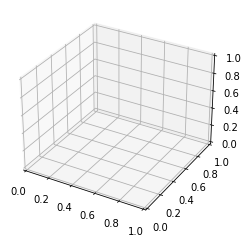

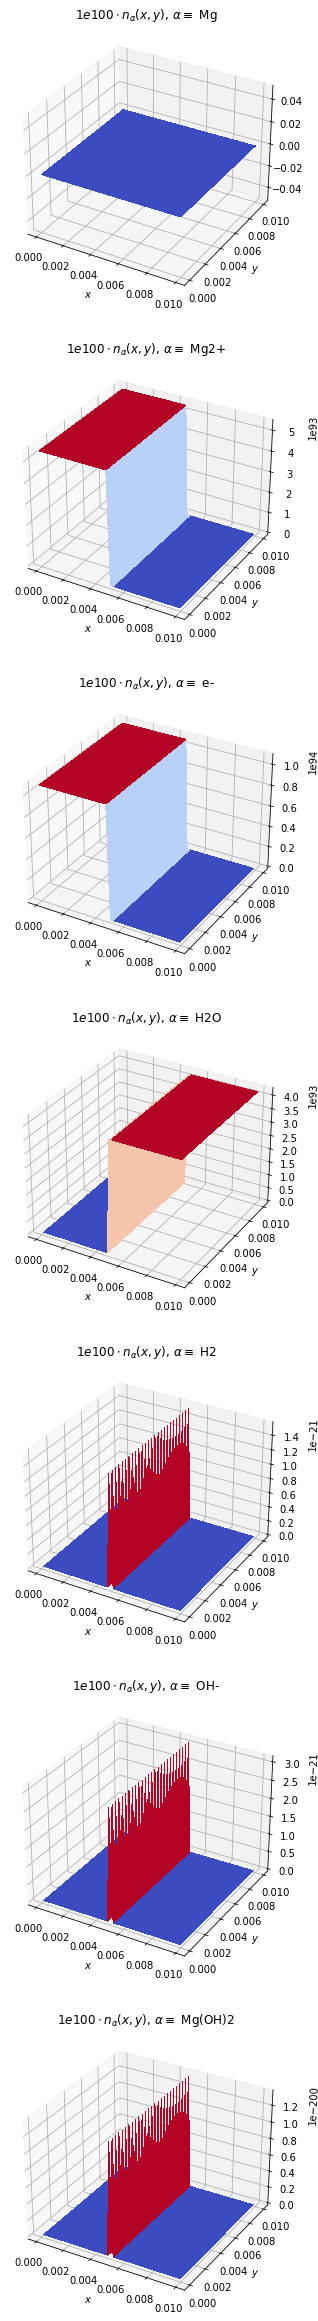

In [148]:
x_ax = np.arange(a/2, Lx - a/2 + 1e-15, a)
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


fig = plt.figure(figsize=(20, 42))

for i in range(len(alpha_names)):
    
    ax = fig.add_subplot(len(alpha_names), 1, i+1, projection='3d')
    ax.plot_surface(xx, yy, n_alpha[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(r'$ n_\alpha(x,y)$, $\alpha \equiv$ {}'.format(alpha_names[i]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$\,$')
    
plt.show()     


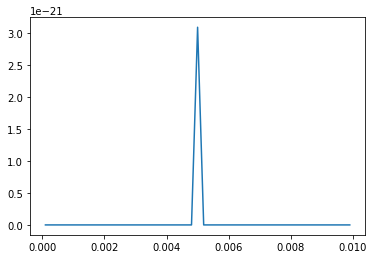

In [140]:
plt.plot(x_ax, 1e100 * n_alpha[-2,1,:])

In [125]:
n_alpha[-1,N_mid,N_mid]

1.3532822760471542e-300

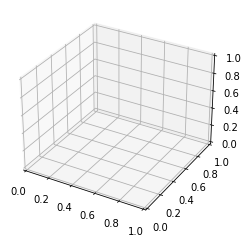

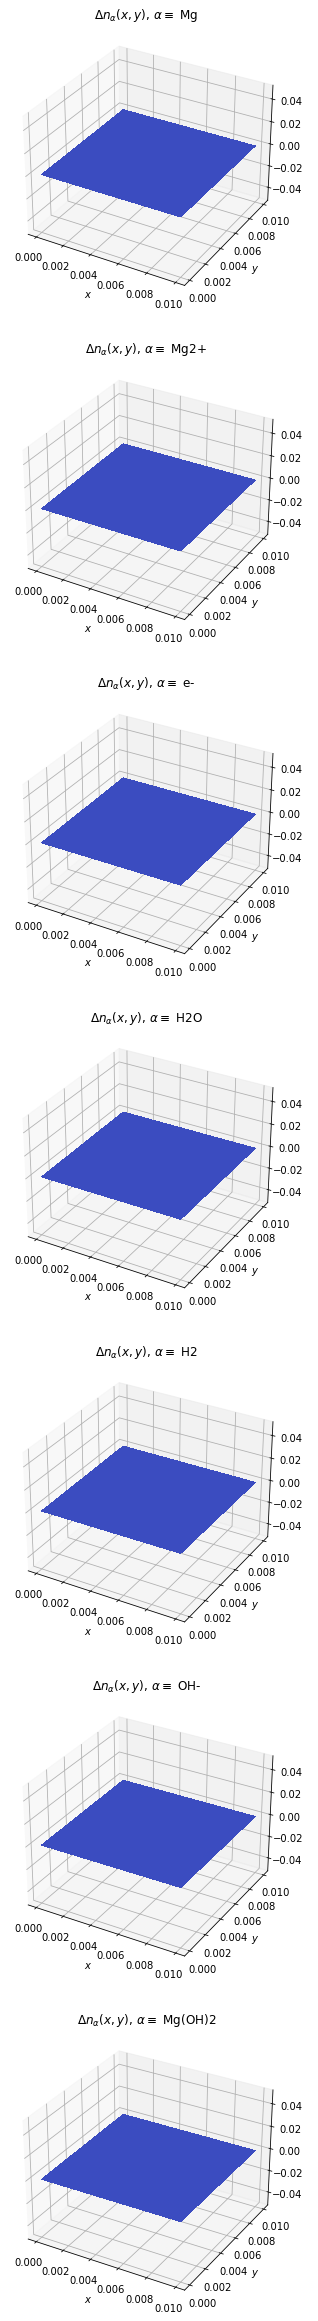

In [126]:
x_ax = np.arange(a/2, Lx - a/2 + 1e-15, a)
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


fig = plt.figure(figsize=(20, 42))

for i in range(len(alpha_names)):
    
    ax = fig.add_subplot(len(alpha_names), 1, i+1, projection='3d')
    ax.plot_surface(xx, yy, n_original[i] - n_alpha[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(r'$\Delta n_\alpha(x,y)$, $\alpha \equiv$ {}'.format(alpha_names[i]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$\,$')
    
plt.show()     

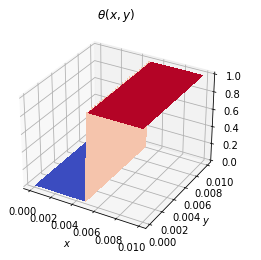

In [127]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, theta, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\theta(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$\,$')
plt.show()

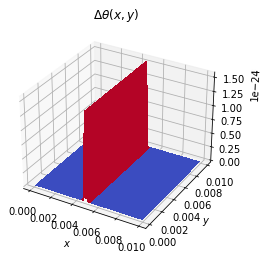

In [128]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, theta - theta_0, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\Delta \theta(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$\,$')
plt.show()

()


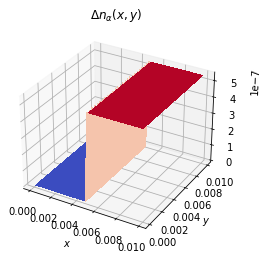

In [79]:
nn_Mg = np.zeros((Nx, Ny))


print(np.shape(n_Mg))

nn_Mg[:, :N_mid] = n_Mg


X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_Mg - n_alpha[1] , cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\Delta n_\alpha(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$\,$')
plt.show()

In [73]:
n_Mg

5.396884137788464e-07

In [74]:
n_Mg - n_alpha[1]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39688414e-07, 5.39688414e-07, 5.39688414e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39688414e-07, 5.39688414e-07, 5.39688414e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39688414e-07, 5.39688414e-07, 5.39688414e-07],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39688414e-07, 5.39688414e-07, 5.39688414e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39688414e-07, 5.39688414e-07, 5.39688414e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39688414e-07, 5.39688414e-07, 5.39688414e-07]])

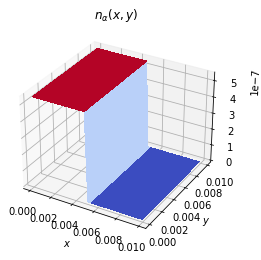

In [75]:
xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_alpha[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$ n_\alpha(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$\,$')
plt.show()

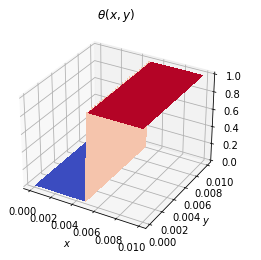

In [76]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, theta, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\theta(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$\,$')
plt.show()

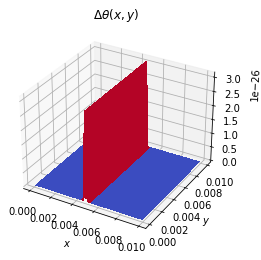

In [77]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, theta - theta_0, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\Delta \theta(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$\,$')
plt.show()

In [44]:
(theta - theta_0)[N_mid-1, N_mid-1]

3.1123899295204504e-26

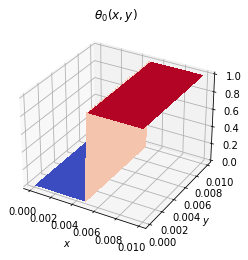

In [39]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Nx, Ny))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, theta_0, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\theta_0(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [ ]:
Na = 31
Nx = Na
Ny = Na
T = 300
k_B = 1e2
a = 1.0/Na
dt = 2 * a**2
t_max = 10 * dt #2000
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([-1, 2, 0]) # e^-, Mg^2+, H2O  #np.array([25, -25])
A_alpha = np.array([1,1,1])
mu_bar_alpha_0 = 1 + np.zeros((3, Na * Na))  # different mu_bar values for the alphas
mu_bar_alpha_1 = 100 + np.zeros((3, Na * Na))  # different mu_bar values for the alphas
D_alpha = 1e-1 * np.ones((3, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha = np.zeros((3, Na, Na))

n_CPFM_1D_forward = np.zeros((3, Na, Na))

X = x_ax
Y = x_ax
xx, yy = np.meshgrid(X, Y)
#theta = 0.1 * np.sin(np.pi * xx) * np.sin(np.pi * yy) 

N_mid = int((Na-1)/2)
#theta = np.zeros((Na, Na))
#theta[:,:N_mid] = 1.0
#theta[:,N_mid:N_mid+2] = 0.5
#theta[:,:] = np.linspace(0,1,Na)

theta = np.zeros((Na, Na))
theta[:,:N_mid] = 0.0
#theta[:,N_mid:N_mid+4] = np.linspace(0.1,1,4)
theta[:,N_mid:] = 1.0

n_alpha[0, :, :N_mid] = 2.0
n_alpha[1, :, :N_mid] = 1.0
n_alpha[2, :, N_mid:] = 1.0

#n_alpha[0, Nx-6:Nx-2, N_mid-2:N_mid+2] += 1.0
#n_alpha[1, 2:6, N_mid-2:N_mid+2] += 1.0
#n_CPFM_1D_forward[:,N_mid-2:N_mid+2, N_mid-2:N_mid+2] = 1.0

#n_alpha = 0.1 * np.ones((3, Na, Na))
#n_CPFM_1D_forward = 0.1 * np.ones((3, Na, Na))


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_alpha[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$n_\alpha(x,y)$, $e^-$, Charge : $-$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

